In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cygrid import WcsGrid
import pyweaver

Use built-in function to create some mock data. The `create_mock_data` function will also mimic the PSF or antenna beam (a simple 2D Gaussian) when generating the data. For basket-weaving, one needs two more or less orthogonal coverages of the same sky region. Therefore, we'll get two mock data sets, one for each coverage.

In [3]:
poly_order = (1, 1)
beam_fwhm = 10 / 60  # degrees

In [4]:
map_header, mock1, mock2 = pyweaver.create_mock_data(
    map_size=(5, 5.5),  # degrees
    beam_fwhm=beam_fwhm,
    map_rms=0.5,
    poly_order=poly_order,
    )

Need to define the gridding kernel (for cygrid)

In [5]:
kernel_sigma = beam_fwhm / 2 / np.sqrt(8 * np.log(2))
kernel_params = (
    'gauss1d', (kernel_sigma, ), 3 * kernel_sigma, kernel_sigma / 2
    )


In [6]:
map1, wmap1, bw_maps1, map2, wmap2, bw_maps2 = pyweaver.compute_maps(
    mock1.lons, mock1.lats, mock1.dirty,
    mock2.lons, mock2.lats, mock2.dirty,
    map_header,
    kernel_params,
    poly_order=poly_order,
    )

Grid some of the auxillary maps, for testing purposes, only.

In [7]:
tmp_header = map_header.copy()
tmp_header['NAXIS3'] = 3
gridder = WcsGrid(tmp_header)
gridder.set_kernel(*kernel_params)
gridder.grid(
    np.hstack(mock1.lons + mock2.lons),
    np.hstack(mock1.lats + mock2.lats),
    np.vstack([
        np.hstack(mock1.offsets + mock2.offsets),
        np.hstack(mock1.model + mock2.model),
        np.hstack(mock1.clean + mock2.clean),
        ]).T
    )
offset_map, model_map, clean_map = gridder.get_datacube()

Now, do the actual basket-weaving. First create the necessary matrices

In [8]:
bw_mat, bw_mat_recon = pyweaver.compute_bw_matrices(
    bw_maps1, wmap1, bw_maps2, wmap2,
    poly_order=poly_order, dampening=0.1,
    )

Now solve the problem, also get a correction map in the process

In [9]:
diff_map = map1 - map2
poly_coeffs, correction_map, fit_map = pyweaver.solve_bw(
    bw_mat, bw_mat_recon, diff_map
    )

/home/bwinkel/local/miniconda3new/envs/cygrid-test-3.6/lib/python3.6/site-packages/pyweaver-0.1.0.dev15-py3.6.egg/pyweaver/weaver.py:171: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  presult = np.linalg.lstsq(A, dirty_vec)


In [10]:
dirty_map = (map1 * wmap1 + map2 * wmap2) / (wmap1 + wmap2)
cleaned_map = dirty_map - correction_map
residual_map = cleaned_map - clean_map


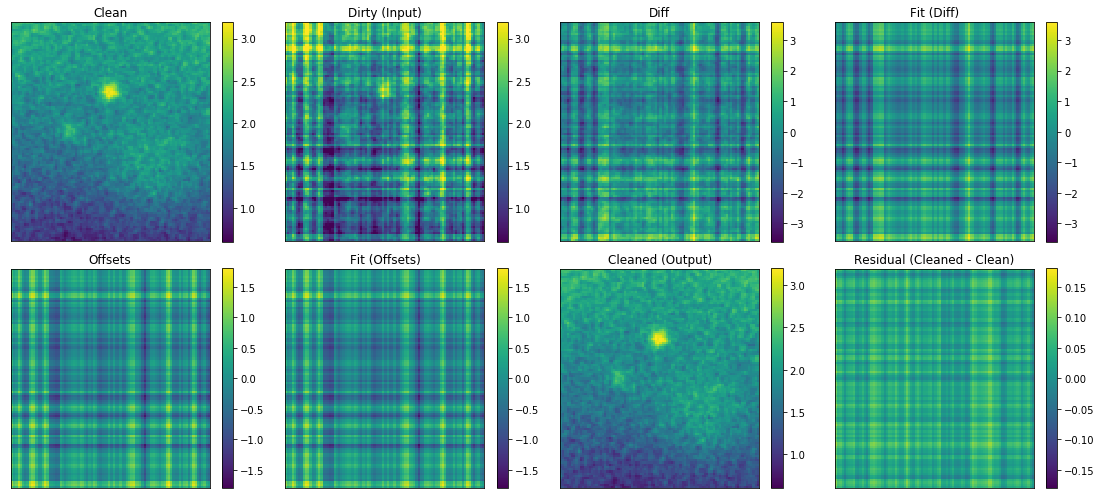

In [11]:
plt.close()
fig, axes = plt.subplots(2, 4, figsize=(15.5, 7))
ims = [
    axes[idx // 4, idx % 4].imshow(
        dat, origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax
        )
    for idx, (dat, vmin, vmax) in enumerate([
        # model_map,
        (clean_map, 0.6, 3.2),
        (dirty_map, 0.6, 3.2),
        (diff_map, -3.6, 3.6),
        (fit_map, -3.6, 3.6),
        (offset_map, -1.8, 1.8),
        (correction_map, -1.8, 1.8),
        (cleaned_map, 0.6, 3.2),
        (residual_map, -0.18, 0.18),
        ])
    ]
for im, ax, title in zip(
        ims, axes.flat, [
            # 'model_map',
            'Clean', 'Dirty (Input)', 'Diff', 'Fit (Diff)',
            'Offsets', 'Fit (Offsets)', 'Cleaned (Output)',
            'Residual (Cleaned - Clean)'
            ]):
    fig.colorbar(im, ax=ax)
    ax.set_title(title)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

fig.tight_layout()
plt.show()